<h1><b><center>CLASIFICACIÓN DE NORMALIDAD EN TEJIDO DE MAMAS A PARTIR DE IMÁGENES DIGITALES DE RAYOS X</center></h1>

|<h2><font color='white'>-----------------------</font><b>DIEGO FERNANDO VELASCO GIRALDO||
|---|---|
|||
|||
| <left><font size="4">Estudiante de Maestría en Ingeniería con Énfasis en Ingeniería Electrónica</font> | <center><img src="https://drive.google.com/uc?id=1CtdK5Litx2pQmTGD3U2Qs0MxIVs_nB8H" width="55" height="80" /> |
|||
| <left><font size="4">Grupo de Investigación Percepción y Sistemas Inteligentes - Univalle</font> | <center><img src="https://drive.google.com/uc?id=1qEQd1k3SOIeLx-X0OSYQ0DosajsIy9Vc" width="165" height="70" /> |
|||
| <left><i><font size="4">Correo Electrónico: diego.fernando.velasco@correounivalle.edu.co</font></i> | <center><i><font size="4">Celular: 3234777477</font></i> |
|||

<center><h4><i>Proyecto de Grado - Modalidad: Profundización - Universidad del Valle - Director: Humberto Loaiza, Ph.D.</i></h4>
<br>

## Librerías necesarias

In [ ]:
# import the necessary packages
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
#import argparse
import cv2
import glob
import os
import shutil
from pandas import DataFrame
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import local_binary_pattern
from scipy.stats import entropy
import math

## Montaje drive de Google y verificación de GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Mounted at /content/drive
/content/drive/MyDrive/Implementación Proyecto Grado Maestría
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


## Carga y data wrangling de metadatos del mini-MIAS dataset

In [ ]:
dataPath = "all-mias"
nn_svm_hog_folder = '/nn_svm_hog'

textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head(3)

#values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
#mias_df = mias_df.fillna(value=values)
#mias_df.head(3)

#mias_df.X = mias_df.X.astype(int)
#mias_df.Y = mias_df.Y.astype(int)
#mias_df.RADIUS = mias_df.RADIUS.astype(int)
#mias_df.head(3)

#mias_df.loc[mias_df["SEVERITY"] !='N', "SEVERITY"] = 'A'
#mias_df.head(3)
#print(mias_df)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN


In [ ]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)
mias_df.head(3)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,N,0.0,0.0,0.0


In [ ]:
print(mias_df.shape)
mias_df_uniques = mias_df.drop_duplicates(subset = ["REFNUM"])
benign_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='B']
malignant_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='M']
normal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='N']
print("Number of benign images: ", benign_uniques.shape)
print("Number of malignant images: ", malignant_uniques.shape)
print("Number of normal images: ",normal_uniques.shape)

(330, 7)
Number of benign images:  (62, 7)
Number of malignant images:  (51, 7)
Number of normal images:  (209, 7)


In [ ]:
mias_df.loc[mias_df["SEVERITY"] !='N', "SEVERITY"] = 'A'
mias_df.head(3)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,A,535.0,425.0,197.0
1,mdb002,G,CIRC,A,522.0,280.0,69.0
2,mdb003,D,NORM,N,0.0,0.0,0.0


In [ ]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
#mias_df.head(3)
print(mias_df)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        A  535  425     197
1    mdb002  G  CIRC        A  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        A  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[330 rows x 7 columns]


In [ ]:
mias_df_new = mias_df.drop(mias_df[(mias_df['SEVERITY'] == 'A') & (mias_df['RADIUS'] == 0)].index)
print(mias_df_new)

print('\nAbnormal with no X, Y labeled: \n', mias_df[(mias_df['SEVERITY'] == 'A') & (mias_df['RADIUS'] == 0)])

print("\nLabeled abnormalities (more than one in some images) and labeled as normal: ", mias_df_new.shape)

#Split by class:
abnormalClass = mias_df_new[mias_df_new.SEVERITY=='A']
print("Labeled as abnormal: ", abnormalClass.shape)
normalClass = mias_df_new[mias_df_new.SEVERITY=='N']
print("Labeled as normal: ", normalClass.shape)

#Unique REFNUM:
mias_df_uniques = mias_df_new.drop_duplicates(subset = ["REFNUM"]) #REFNUM únicos porque se repiten para número de imgs no de anormalidades presentes
abnormal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='A']
normal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='N']
print("\nNumber of images: ", mias_df_uniques.shape)
print("Number of abnormal images: ", abnormal_uniques.shape)
print("Number of normal images: ", normal_uniques.shape)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        A  535  425     197
1    mdb002  G  CIRC        A  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        A  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[326 rows x 7 columns]

Abnormal with no X, Y labeled: 
      REFNUM BG CLASS SEVERITY  X  Y  RADIUS
59   mdb059  F  CIRC        A  0  0       0
218  mdb216  D  CALC        A  0  0       0
238  mdb233  G  CALC        A  0  0       0
251  mdb245  F  CALC        A  0  0       0

Labeled abnormalities (more than one in some images) and labeled as normal:  (326, 7)
Labeled as abnormal:  (117, 7)
Labeled as normal:  (209, 7)

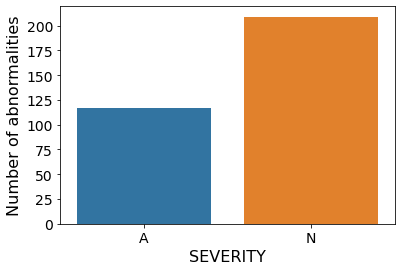

In [ ]:
ax = sns.countplot(x="SEVERITY", data=mias_df_new)
ax.set_xlabel("SEVERITY",fontsize=16)
ax.set_ylabel("Number of abnormalities",fontsize=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
# plt.grid(False)
plt.show()

## Copia de imágenes correspondientes a carpetas normal y anormal

In [ ]:
dataPath01 = dataPath + nn_svm_hog_folder
if os.path.isdir(dataPath01) is False:
  os.mkdir(dataPath01)

orig_path = dataPath+'/allmias_PNG_mat_eq/'
comp_name = '_output.png'

abnormal_fileNames = abnormalClass.REFNUM
normal_fileNames = normalClass.REFNUM

abnormal_train_path = dataPath01+'/train/abnormal/'
normal_train_path = dataPath01+'/train/normal/'

if os.path.isdir(abnormal_train_path) is False:
    os.makedirs(abnormal_train_path)
    os.makedirs(normal_train_path)

    for image_name in abnormal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', benign_processed_path)
        shutil.copy(orig_path + image_name + comp_name, abnormal_train_path)

    for image_name in normal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', normal_processed_path)
        shutil.copy(orig_path + image_name + comp_name, normal_train_path)

## Extracción de patches de anormalidades
Se extraen patches de las anormalidades utilizando las coordenadas X, Y y radio suministradas en los metadatos

In [ ]:
#Saco patches de las anormales:

#abnormal_path = dataPath01+'/abnormal/'
abnormal_images = glob.glob(abnormal_train_path+'*.png')
abnormal_images = sorted(abnormal_images)

ab_patches_train_path = (dataPath01+'/train/abnormal_patches/')

if os.path.isdir(ab_patches_train_path) is False:
  os.mkdir(ab_patches_train_path)

  patches = []
  patches_names = []

  color = 255

  for file_path in abnormal_images:
      image = cv2.imread(file_path,0)
      basename = os.path.basename(file_path)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
      name = name[:6]
      roi_df = mias_df_new.loc[mias_df_new['REFNUM'] == name, ['X', 'Y', 'RADIUS']]
      roi_values = roi_df.values
      height, width = image.shape[:2] #height, width, without number of channels
      for row, i in zip(roi_values, range(len(roi_values))):
          zeros_image = np.zeros(image.shape[:2], np.uint8)
          i=i+1
          X, Y, RADIUS = row
          Y_new = height - Y
          mask = cv2.rectangle(zeros_image, (X-RADIUS, Y_new+RADIUS), (X+RADIUS, Y_new-RADIUS), color, cv2.FILLED)
          x, y = np.nonzero(mask)
          xl,xr = x.min(),x.max()
          yl,yr = y.min(),y.max()
          cropped_img = image[xl:xr, yl:yr]
          cropped_img = cv2.resize(cropped_img, (64,64))
          patches.append(cropped_img)
          if (len(roi_values) == 1):
            patches_names.append(name+'_patch')
          else:
            patches_names.append(name+'_patch'+str(i))

  print(len(patches))

  for patch, patch_name in zip(patches, patches_names):
      cv2.imwrite((ab_patches_train_path + patch_name + '.png'), patch)

## Extracción de patches de mamas normales
Se extraen patches aleatorios de la misma dimension de los anteriores, pero de las mamas normales.

In [ ]:
#Saco patches de las normales:

#normal_path = dataPath01+'/normal/'
normal_images = glob.glob(normal_train_path+'*.png')
normal_images = sorted(normal_images)

nor_patches_train_path = (dataPath01+'/train/normal_patches/')

if os.path.isdir(nor_patches_train_path) is False:
  os.mkdir(nor_patches_train_path)

  patches = []
  patches_names = []

  color = 255

  for file_path in normal_images:
      image = cv2.imread(file_path,0)
      basename = os.path.basename(file_path)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
      name = name[:6]
      for i in range(2):
          zeros_image = np.zeros(image.shape[:2], np.uint8)
          i=i+1
          X = random.randint(128,700)
          Y = random.randint(128,700)
          mask = cv2.rectangle(zeros_image, (X, Y), (X+64, Y-64), color, cv2.FILLED)
          x, y = np.nonzero(mask)
          xl,xr = x.min(),x.max()
          yl,yr = y.min(),y.max()
          cropped_img = image[xl:xr, yl:yr]
          #cropped_img = cv2.resize(cropped_img, (64,64))
          patches.append(cropped_img)
          patches_names.append(name+'_patch'+str(i))

  print(len(patches))

  for patch, patch_name in zip(patches, patches_names):
      cv2.imwrite((nor_patches_train_path + patch_name + '.png'), patch)

## Movimiento de 20% de las imágenes en abnormal y normal a carpetas de test abnormal y normal

In [ ]:
ab_patches_test_path = dataPath01+'/test/abnormal_patches/'
nor_patches_test_path = dataPath01+'/test/normal_patches/'

if os.path.isdir(ab_patches_test_path) is False:
  os.makedirs(ab_patches_test_path)
  os.makedirs(nor_patches_test_path)

  train_abnorm_imgs = glob.glob(ab_patches_train_path+'*.png')
  train_norm_imgs = glob.glob(nor_patches_train_path+'*.png')

  test_abnorm_imgs = random.sample(train_abnorm_imgs, 23) #aprox. 20% de las imágenes para test.
  test_norm_imgs = random.sample(train_norm_imgs, 84)

  for test_image in test_abnorm_imgs:
      shutil.move(test_image, ab_patches_test_path)

  for test_image in test_norm_imgs:
      shutil.move(test_image, nor_patches_test_path)

## Data Augmentation
Aumento de datos aplicando transformaciones a las imágenes

In [ ]:
def augmentImages(images_paths, dir, imgs_per_image, pixel_fill):
  #images_paths = glob.glob(images_path+'/*.png')

  #imágenes a un arreglo para que sean leídas más rápido cuando haga el augmentation:
  imgs_arr=[]
  imgs_names_arr=[]
  for myFile in images_paths:
    image = cv2.imread(myFile, 0)
    imgs_arr.append(image)
    basename = os.path.basename(myFile)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto
    name = name[:6]
    imgs_names_arr.append(name)

  for myImage, myName in zip(imgs_arr, imgs_names_arr):
    image = np.expand_dims(myImage,(0, 3))
    gen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, fill_mode='constant',
                              cval=pixel_fill, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)# brightness_range=[0.6,1.3])
    #gen = ImageDataGenerator(width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
    #                          cval=min_pixel, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)
    #Save augmented images
    aug_iter = gen.flow(image, save_to_dir=dir, save_prefix='aug_'+myName, save_format='png')
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(imgs_per_image)]

In [ ]:
image = cv2.imread(orig_path + 'mdb001' + comp_name, 0)
pix_fill = image[0][0]

if len(os.listdir(ab_patches_train_path)) == 94:
  abnormal_patches = glob.glob(ab_patches_train_path+'*.png')
  augmentImages(abnormal_patches, ab_patches_train_path, 3, pix_fill)

In [ ]:
def remove_surplus(ab_patches_train_path, nor_patches_train_path):
  a = len(os.listdir(ab_patches_train_path))
  b = len(os.listdir(nor_patches_train_path))
  if  a > b:
    dif = a - b
    for c in random.sample(glob.glob(ab_patches_train_path+'aug'+'*.png'), dif):
      os.remove(c) #Elimino las sobrantes para que quede la misma cantidad de imágenes que en /normal_processed

remove_surplus(ab_patches_train_path, nor_patches_train_path)

## Creación de listas de patches y sus nombres para train y test

In [ ]:
def patches_names_lists(ab_patches_path, nor_patches_path):
    abnormal_patches = glob.glob(ab_patches_path+'*.png')
    abnormal_patches = sorted(abnormal_patches)

    normal_patches = glob.glob(nor_patches_path+'*.png')
    normal_patches = sorted(normal_patches)

    abnormal_patches_lst = []
    normal_patches_lst = []
    abnormal_patches_names = []
    normal_patches_names = []

    for abnormal_patch  in abnormal_patches:
        abnormal_patch_im = cv2.imread(abnormal_patch, 0)
        abnormal_patches_lst.append(abnormal_patch_im)

        basename_ab = os.path.basename(abnormal_patch)
        name_ab = basename_ab[basename_ab.find("mdb"):basename_ab.find("mdb")+6]
        abnormal_patches_names.append(name_ab)

    for normal_patch in normal_patches:
        normal_patch_im = cv2.imread(normal_patch, 0)
        normal_patches_lst.append(normal_patch_im)

        basename_n = os.path.basename(normal_patch)
        name_n = basename_n[basename_n.find("mdb"):basename_n.find("mdb")+6]
        normal_patches_names.append(name_n)

    return abnormal_patches_lst, normal_patches_lst, abnormal_patches_names, normal_patches_names

In [ ]:
#patches_names_lists(ab_patches_train_path, nor_patches_train_path)
ab_train_patches_lst, nor_train_patches_lst, ab_train_patches_names, nor_train_patches_names = patches_names_lists(ab_patches_train_path, nor_patches_train_path)

#patches_names_lists(ab_patches_test_path, nor_patches_test_path)
ab_test_patches_lst, nor_test_patches_lst, ab_test_patches_names, nor_test_patches_names = patches_names_lists(ab_patches_test_path, nor_patches_test_path)

In [ ]:
print(len(ab_test_patches_names))
print(len(nor_test_patches_names))

23
84


## Funciones para extracción de características desde la matriz de co-ocurrencia de nivel de grises (GLCM)

In [ ]:
from skimage.feature import greycomatrix, greycoprops

def get_textural_features(img):
    #img = img_as_ubyte(rgb2gray(img))
    glcm = greycomatrix(img, [1], [0], 256, symmetric=True, normed=True)
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    features = [dissimilarity, correlation, homogeneity, energy]
    return features

In [ ]:
def extract_features_one_image(image):
    METHOD = 'default'
    radius = 1 #Solo cambio este valor (1 el mejor hasta ahora)
    n_points = 8 * radius
    matplotlib.rcParams['font.size'] = 9
    np.seterr(invalid='ignore')
    hist = cv2.calcHist([image], [0], None, [251], [5, 256])
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    lbp = np.array(lbp, dtype=np.uint8)
    lbp_neg = cv2.bitwise_not(lbp)
    lbp_hist = cv2.calcHist([lbp_neg],[0],None,[251],[5,256])
    entropy_im_hist = float(entropy(hist))
    if math.isnan(entropy_im_hist): entropy_im_hist = 0.0
    entropy_lbp_hist = float(entropy(lbp_hist))
    if math.isnan(entropy_lbp_hist): entropy_lbp_hist = 0.0
    data_1 = [float(np.mean(hist)), float(np.median(hist)), entropy_im_hist,
              float(np.mean(lbp_hist)), float(np.median(lbp_hist)), entropy_lbp_hist]
    data_2 = get_textural_features(image)
    data_3 = get_textural_features(lbp_neg)
    stats_data = [*data_1, *data_2, *data_3]
    #stats_data_df = pd.DataFrame(stats_data)
    return stats_data

In [ ]:
def extract_features(patches_lst, patches_names, stats_df):
    METHOD = 'default'
    radius = 1 #Solo cambio este valor (1 el mejor hasta ahora)
    n_points = 8 * radius
    matplotlib.rcParams['font.size'] = 9
    np.seterr(invalid='ignore')

    for image, name in zip(patches_lst, patches_names):
        hist = cv2.calcHist([image], [0], None, [251], [5, 256])
        lbp = local_binary_pattern(image, n_points, radius, METHOD)
        lbp = np.array(lbp, dtype=np.uint8)
        lbp_neg = cv2.bitwise_not(lbp)
        lbp_hist = cv2.calcHist([lbp_neg],[0],None,[251],[5,256])
        df_1 = mias_df_new[mias_df_new['REFNUM'] == name]#.SEVERITY.item()
        data_1 = df_1[['REFNUM', 'SEVERITY']].values.flatten().tolist()
        data_1 = [data_1[0], data_1[1]]
        #data_2 = [float(np.mean(hist)), float(np.std(hist)), float(skew(hist)), float(kurtosis(hist)), float(entropy(hist)),
        #          float(np.mean(lbp_hist)), float(np.std(lbp_hist)), float(skew(lbp_hist)), float(kurtosis(lbp_hist)), float(entropy(lbp_hist))]
        entropy_im_hist = float(entropy(hist))
        if math.isnan(entropy_im_hist): entropy_im_hist = 0.0
        entropy_lbp_hist = float(entropy(lbp_hist))
        if math.isnan(entropy_lbp_hist): entropy_lbp_hist = 0.0
        data_2 = [float(np.mean(hist)), float(np.median(hist)), entropy_im_hist,
                  float(np.mean(lbp_hist)), float(np.median(lbp_hist)), entropy_lbp_hist]
        #data_2 = [float(np.mean(lbp_hist)), float(np.std(lbp_hist)), float(skew(lbp_hist)), float(kurtosis(lbp_hist)), float(entropy(lbp_hist))]
        data_3 = get_textural_features(image)
        data_4 = get_textural_features(lbp_neg)
        stats_data = [*data_1, *data_2, *data_3, *data_4]
        #print(stats_data)
        stats_df.loc[len(stats_df)] = stats_data

In [ ]:
columns = ['REFNUM', 'SEVERITY', 'HIST_MEAN', 'HIST_MEDIAN', 'HIST_ENTROPY', 'LBP_HIST_MEAN', 'LBP_HIST_MEDIAN', 'LBP_HIST_ENTROPY',
             'DISSIMILARITY', 'CORRELATION', 'HOMOGENEITY', 'ENERGY', 'LBP_DISSIMILARITY', 'LBP_CORRELATION', 'LBP_HOMOGENEITY', 'LBP_ENERGY']
stats_df_train = pd.DataFrame(columns = columns)

#np.seterr(divide='ignore', invalid='ignore')
np.seterr(invalid='ignore')
extract_features(ab_train_patches_lst, ab_train_patches_names, stats_df_train)
extract_features(nor_train_patches_lst, nor_train_patches_names, stats_df_train)

stats_df_train.head(3) #display(stats_df_train)
#print(stats_df_train.isnull().sum().sum())

,REFNUM,SEVERITY,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,mdb001,A,14.294821,15.0,5.342287,14.227092,1.0,3.967462,9.608135,0.967523,0.194715,0.095016,47.645585,0.637626,0.291910,0.084982
1,mdb001,A,14.063745,13.0,5.371941,14.067729,1.0,3.903732,9.554067,0.978658,0.200286,0.099953,51.865823,0.569270,0.284130,0.096970
2,mdb001,A,13.892430,13.0,5.369847,13.916335,1.0,3.939059,9.818452,0.970737,0.202119,0.109656,51.602927,0.587127,0.283992,0.095923


In [ ]:
columns = ['REFNUM', 'SEVERITY', 'HIST_MEAN', 'HIST_MEDIAN', 'HIST_ENTROPY', 'LBP_HIST_MEAN', 'LBP_HIST_MEDIAN', 'LBP_HIST_ENTROPY',
             'DISSIMILARITY', 'CORRELATION', 'HOMOGENEITY', 'ENERGY', 'LBP_DISSIMILARITY', 'LBP_CORRELATION', 'LBP_HOMOGENEITY', 'LBP_ENERGY']
stats_df_test = pd.DataFrame(columns = columns)

extract_features(ab_test_patches_lst, ab_test_patches_names, stats_df_test)
extract_features(nor_test_patches_lst, nor_test_patches_names, stats_df_test)

stats_df_test.head(3) #display(stats_df_test)
#print(stats_df_test.isnull().sum().sum())

,REFNUM,SEVERITY,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,mdb012,A,16.318726,8.0,4.755613,14.689243,2.0,4.248358,4.843998,0.981495,0.205358,0.025572,70.840030,0.438076,0.126826,0.039288
1,mdb013,A,16.318726,1.0,4.567416,14.928287,1.0,3.991448,2.530258,0.993764,0.358594,0.043424,52.235615,0.620786,0.200081,0.064649
2,mdb032,A,16.318726,16.0,4.955676,14.689243,3.0,4.209592,5.341022,0.985209,0.207376,0.023714,61.931300,0.530802,0.153138,0.053970


In [ ]:
#Split features and labels:
features_train = stats_df_train.drop(['REFNUM', 'SEVERITY'],axis=1)
labels_train = stats_df_train.SEVERITY
#labels_train.replace({'A': 0, 'N': 1}, inplace=True)

display(features_train)
display(labels_train)

#print(features)
#print(labels)

,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,14.294821,15.0,5.342287,14.227092,1.0,3.967462,9.608135,0.967523,0.194715,0.095016,47.645585,0.637626,0.291910,0.084982
1,14.063745,13.0,5.371941,14.067729,1.0,3.903732,9.554067,0.978658,0.200286,0.099953,51.865823,0.569270,0.284130,0.096970
2,13.892430,13.0,5.369847,13.916335,1.0,3.939059,9.818452,0.970737,0.202119,0.109656,51.602927,0.587127,0.283992,0.095923
3,14.876494,7.0,4.796910,14.039841,1.0,3.884106,7.677579,0.899846,0.280410,0.069794,53.727431,0.562964,0.269229,0.091570
4,14.617530,10.0,4.919968,13.737052,1.0,3.915002,5.337302,0.971540,0.297890,0.092968,51.294147,0.605999,0.289460,0.110300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,16.318726,0.0,4.113790,13.637450,3.0,4.448380,5.885913,0.877822,0.195261,0.036470,88.930804,0.263185,0.074188,0.036014
664,16.318726,2.0,4.602547,14.051793,3.0,4.255864,2.965774,0.991036,0.306059,0.036998,81.689980,0.209136,0.080067,0.037270
665,6.629482,0.0,2.010128,4.693227,0.0,3.546996,0.932788,0.963721,0.788668,0.596011,44.839286,0.368538,0.641825,0.609798
666,0.000000,0.0,0.000000,1.418327,0.0,1.525773,0.024554,0.955178,0.987723,0.691752,9.133433,0.582290,0.920520,0.891314


0      A
1      A
2      A
3      A
4      A
      ..
663    N
664    N
665    N
666    N
667    N
Name: SEVERITY, Length: 668, dtype: object

In [ ]:
features_test = stats_df_test.drop(['REFNUM', 'SEVERITY'],axis=1)
labels_test = stats_df_test.SEVERITY
#labels_test.replace({'A': 0, 'N': 1}, inplace=True)

display(features_test)
display(labels_test)

,HIST_MEAN,HIST_MEDIAN,HIST_ENTROPY,LBP_HIST_MEAN,LBP_HIST_MEDIAN,LBP_HIST_ENTROPY,DISSIMILARITY,CORRELATION,HOMOGENEITY,ENERGY,LBP_DISSIMILARITY,LBP_CORRELATION,LBP_HOMOGENEITY,LBP_ENERGY
0,16.318726,8.0,4.755613,14.689243,2.0,4.248358,4.843998,0.981495,0.205358,0.025572,70.840030,0.438076,0.126826,0.039288
1,16.318726,1.0,4.567416,14.928287,1.0,3.991448,2.530258,0.993764,0.358594,0.043424,52.235615,0.620786,0.200081,0.064649
2,16.318726,16.0,4.955676,14.689243,3.0,4.209592,5.341022,0.985209,0.207376,0.023714,61.931300,0.530802,0.153138,0.053970
3,16.318726,16.0,4.926003,15.505976,1.0,3.590327,2.712302,0.996399,0.358420,0.034241,39.391865,0.694103,0.328330,0.095695
4,16.318726,11.0,4.830153,15.223107,1.0,3.817388,2.791915,0.995786,0.337639,0.035334,46.748512,0.664556,0.236513,0.085286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,16.318726,0.0,4.389631,12.557769,3.0,4.171442,2.377232,0.989136,0.342620,0.041545,102.487351,0.009841,0.056384,0.047925
103,16.318726,0.0,3.829626,13.525896,3.0,4.414030,5.477183,0.811023,0.198330,0.041792,87.199901,0.304045,0.073167,0.038103
104,16.318726,1.0,4.601772,13.792829,3.0,4.415136,5.324901,0.962600,0.193433,0.026920,86.119048,0.274895,0.079697,0.032879
105,16.318726,7.0,4.705695,14.318725,3.0,4.077912,3.043899,0.991123,0.278448,0.032967,75.873016,0.238547,0.104491,0.050419


0      A
1      A
2      A
3      A
4      A
      ..
102    N
103    N
104    N
105    N
106    N
Name: SEVERITY, Length: 107, dtype: object

In [ ]:
labels_train_ohe = pd.get_dummies(data=labels_train)
labels_test_ohe = pd.get_dummies(data=labels_test)
print(labels_train_ohe)
print(labels_test_ohe)

     A  N
0    1  0
1    1  0
2    1  0
3    1  0
4    1  0
..  .. ..
663  0  1
664  0  1
665  0  1
666  0  1
667  0  1

[668 rows x 2 columns]
     A  N
0    1  0
1    1  0
2    1  0
3    1  0
4    1  0
..  .. ..
102  0  1
103  0  1
104  0  1
105  0  1
106  0  1

[107 rows x 2 columns]


In [ ]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout #Activation
from keras.utils import to_categorical, plot_model

x_train = features_train.values
y_train = labels_train_ohe.values
x_test = features_test.values
y_test = labels_test_ohe.values

#y_train =
#_test =

print (x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print (type(x_train), type(x_test), type(y_train), type(y_test))
#input_dim = x_train.shape[1]
#print('input dimension: '+str(input_dim))
#classes = y_train.shape[1]
#print('number of classes: '+str(classes))

#print(trainY.value_counts())
#print(np.unique(trainY, return_counts=True))
#print(testY.value_counts())
#print(np.unique(testY, return_counts=True))

(668, 14) (107, 14) (668, 2) (107, 2)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Creation of MLP Model

In [ ]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

try: model
except NameError: model = None

if model is None:
  model = Sequential()
  model.add(Dense(19, input_dim=14))
  model.add(Activation('relu'))
  #model.add(Dropout(0.15))
  #model.add(Dense(128))
  #model.add(Activation('relu'))
  model.add(Dropout(0.15))
  model.add(Dense(2))
  model.add(Activation('softmax'))
else:
  del model

## Training the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

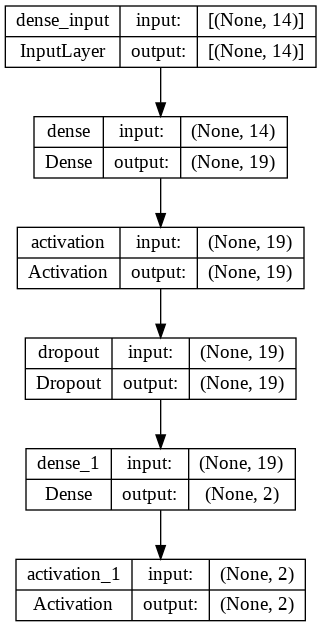

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# v 69.138% train, el resto de validación (16.1%) del total de datos
epochs = 40
training = model.fit(x_train, y_train, validation_split=0.161, batch_size=2, epochs=epochs)# batch_size=32 , epochs=epochs) #batch_size= 20 para que sean 8 pasos por epoch porque son 257 imágenes de train = 257/20 = 12.85


Epoch 1/40
280/280 [==============================] - 3s 3ms/step - loss: 5.3407 - accuracy: 0.5250 - val_loss: 0.1755 - val_accuracy: 0.9167
Epoch 2/40
280/280 [==============================] - 1s 3ms/step - loss: 2.2556 - accuracy: 0.7161 - val_loss: 0.2876 - val_accuracy: 0.9074
Epoch 3/40
280/280 [==============================] - 1s 3ms/step - loss: 1.3215 - accuracy: 0.8036 - val_loss: 0.1887 - val_accuracy: 0.9444
Epoch 4/40
280/280 [==============================] - 1s 3ms/step - loss: 0.7427 - accuracy: 0.8536 - val_loss: 0.1847 - val_accuracy: 0.9444
Epoch 5/40
280/280 [==============================] - 1s 3ms/step - loss: 0.4233 - accuracy: 0.9000 - val_loss: 0.0782 - val_accuracy: 0.9815
Epoch 6/40
280/280 [==============================] - 1s 3ms/step - loss: 0.4250 - accuracy: 0.9036 - val_loss: 0.0947 - val_accuracy: 0.9722
Epoch 7/40
280/280 [==============================] - 1s 3ms/step - loss: 0.3163 - accuracy: 0.9125 - val_loss: 0.3131 - val_accuracy: 0.8981
Epoch 

In [ ]:
#evaluation of the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print('Model loss: %.2f, Accuracy: %.2f' % ((loss*100),(accuracy*100)))

4/4 - 0s - loss: 0.0805 - accuracy: 0.9720 - 121ms/epoch - 30ms/step
Model loss: 8.05, Accuracy: 97.20


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


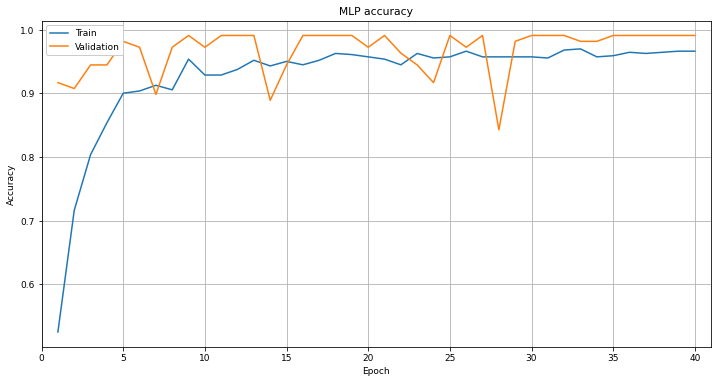

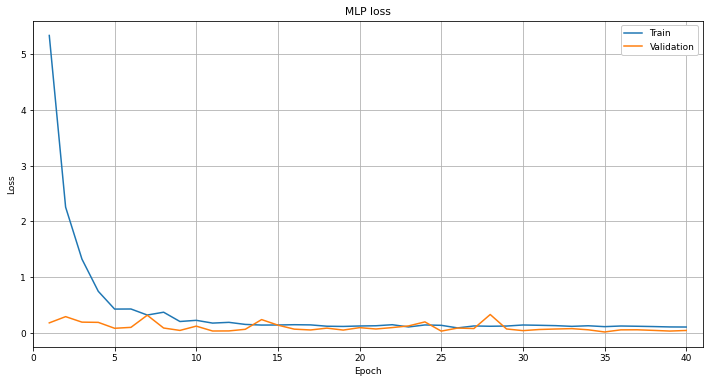

In [ ]:
# list all data in history
print(training.history.keys())
#print(history.history['accuracy'])

# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), training.history['accuracy'])
plt.plot(np.arange(1, epochs+1, 1), training.history['val_accuracy'])
#plt.plot(np.arange(1, epochs+1, 1), model_history.history['val_accuracy'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('MLP accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', framealpha=1)
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), training.history['loss'])
plt.plot(np.arange(1, epochs+1, 1), training.history['val_loss'])
#plt.plot(np.arange(1, epochs+1, 1), model_history.history['val_loss'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('MLP loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', framealpha=1)#, fancybox=True)
plt.grid()
plt.show()

#plt.savefig('01_DenseNet121_DFV.jpg', dpi=200)

#-----------------------------------------------------------

In [ ]:
from matplotlib import pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.grid(False)

In [ ]:
y_pred = model.predict(x_test)

y_test_decoded = y_test.argmax(axis=1)
y_pred_decoded = y_pred.argmax(axis=1)


cm = confusion_matrix(y_test_decoded, y_pred_decoded)
print(cm)

#cm = confusion_matrix(model.predict(x_test), y_test)
#cm_plot_labels = ['Abnormal', 'Normal']
#plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='MLP Confusion Matrix (Test)')

4/4 [==============================] - 0s 2ms/step
[[21  2]
 [ 1 83]]


Confusion matrix, without normalization
[[21  2]
 [ 1 83]]


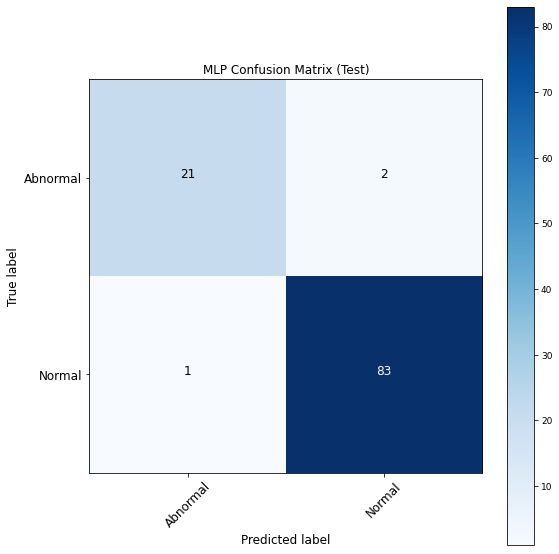

In [ ]:
cm_plot_labels = ['Abnormal', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='MLP Confusion Matrix (Test)')

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('Accuracy MLP (Test): ',accuracy_score(y_test_decoded, y_pred_decoded))
print('Recall MLP (Test): ',recall_score(y_test_decoded, y_pred_decoded))
print('Precision MLP (Test): ',precision_score(y_test_decoded, y_pred_decoded))
print('F1 Score MLP (Test): ',f1_score(y_test_decoded, y_pred_decoded))

Accuracy MLP (Test):  0.9719626168224299
Recall MLP (Test):  0.9880952380952381
Precision MLP (Test):  0.9764705882352941
F1 Score MLP (Test):  0.9822485207100591


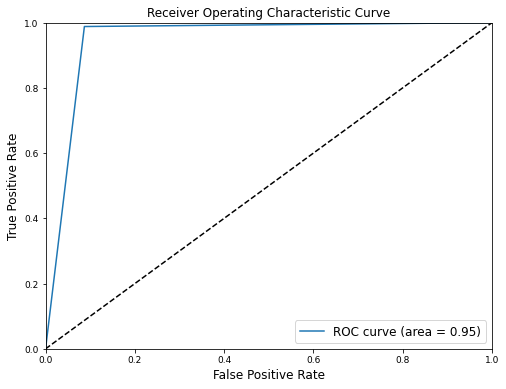

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve (y_test_decoded, y_pred_decoded)
auc_score=roc_auc_score(y_test_decoded,y_pred_decoded)

def plot_roc_curve(fpr, tpr):
  fig, ax = plt.subplots(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %auc_score)
  plt.axis([0,1,0,1])
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate', fontsize=12)
  plt.ylabel('True Positive Rate', fontsize=12)
  plt.title('Receiver Operating Characteristic Curve', fontsize=12)
  plt.legend(loc="lower right", fontsize=12)
  plt.show()

plot_roc_curve (fpr, tpr)

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', probability=True)  #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’

y_train_decoded = y_train.argmax(axis=1)

svclassifier.fit(x_train, y_train_decoded)

#y_pred = svclassifier.predict(testX)

from sklearn.metrics import classification_report, confusion_matrix
print(svclassifier.score(x_train, y_train_decoded))
#print(confusion_matrix(y_pred,testY))
print(confusion_matrix(svclassifier.predict(x_train), y_train_decoded))
#print(classification_report(testY,y_pred))
print(len(x_train))

0.9790419161676647
[[326   6]
 [  8 328]]
668


In [ ]:
y_pred_svm = svclassifier.predict(x_test)

#y_test_decoded = y_test.argmax(axis=1)
#y_pred_decoded = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test_decoded, y_pred_svm)
print(cm)


[[21  2]
 [ 1 83]]


Confusion matrix, without normalization
[[21  2]
 [ 1 83]]


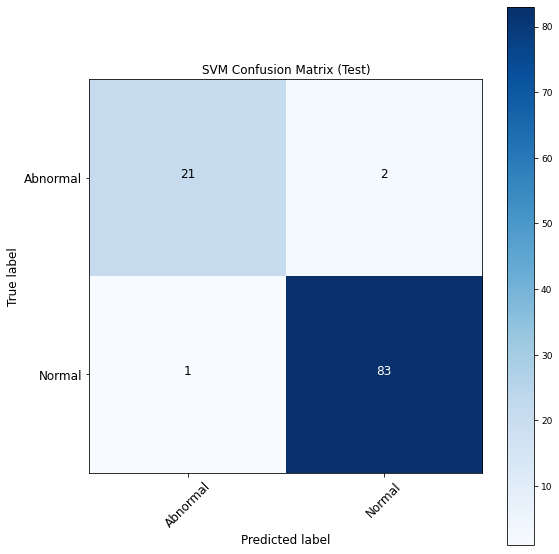

In [ ]:
cm_plot_labels = ['Abnormal', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='SVM Confusion Matrix (Test)')

In [ ]:
print('Accuracy SVM (Test): ', accuracy_score(y_test_decoded, y_pred_svm))
print('Recall SVM (Test): ', recall_score(y_test_decoded, y_pred_svm))
print('Precision SVM (Test): ', precision_score(y_test_decoded, y_pred_svm))
print('F1 Score SVM (Test): ', f1_score(y_test_decoded, y_pred_svm))

Accuracy SVM (Test):  0.9719626168224299
Recall SVM (Test):  0.9880952380952381
Precision SVM (Test):  0.9764705882352941
F1 Score SVM (Test):  0.9822485207100591


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_decoded, y_pred_svm))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.98      0.99      0.98        84

    accuracy                           0.97       107
   macro avg       0.97      0.95      0.96       107
weighted avg       0.97      0.97      0.97       107



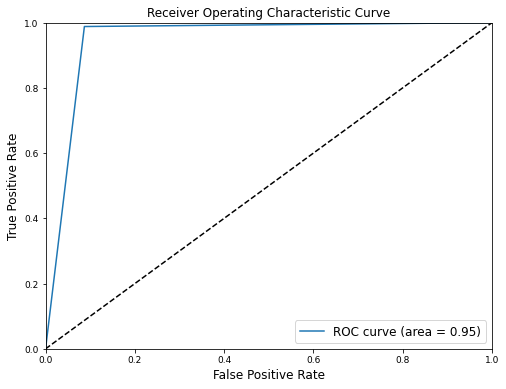

In [ ]:
fpr, tpr, thresholds = roc_curve (y_test_decoded, y_pred_svm)
auc_score=roc_auc_score(y_test_decoded,y_pred_svm)

def plot_roc_curve(fpr, tpr):
  fig, ax = plt.subplots(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %auc_score)
  plt.axis([0,1,0,1])
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate', fontsize=12)
  plt.ylabel('True Positive Rate', fontsize=12)
  plt.title('Receiver Operating Characteristic Curve', fontsize=12)
  plt.legend(loc="lower right", fontsize=12)
  plt.show()

plot_roc_curve (fpr, tpr)

## ------------------------------------

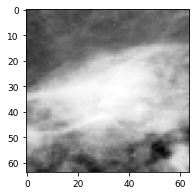

          0     1         2          3    4         5         6         7   \
0  16.318726  16.0  4.955676  14.689243  3.0  4.209592  5.341022  0.985209   

         8         9        10        11        12       13  
0  0.207376  0.023714  61.9313  0.530802  0.153138  0.05397  

Prediction:  [0]

Prediction proba:  [[0.95454079 0.04545921]]
0.9545407864563272
Es anormal y pasó el umbral de rechazo

 Prueba: 0.9545407864563272 [0]


In [ ]:
test_image = cv2.imread(ab_patches_test_path+'mdb032_patch.png', 0)
#test_image = cv2.resize(test_image, (64,64))
plt.figure(figsize=(3, 3))
plt.imshow(test_image, cmap='gray')
plt.show()

x_features = extract_features_one_image(test_image)
x_features = pd.DataFrame(x_features).T
#x_features = x_features.fillna(value=0.0)
#x_features = x_features.T
#x_features = np.array(x_features)
#x_features = x_features.reshape(1,-1)
#x_features = scaler.transform(x_features)
#display(x_features)
print(x_features)
y_pred = svclassifier.predict(x_features)
y_pred_proba = svclassifier.predict_proba(x_features)
print('\nPrediction: ',y_pred)
print('\nPrediction proba: ',y_pred_proba)

print(max(y_pred_proba.max(axis=1)))

if max(y_pred_proba.max(axis=1))>=0.9:
  print("Es anormal y pasó el umbral de rechazo")
else:
  print("Es anormal pero no pasó el umbral de rechazo")


print('\n Prueba:', max(y_pred_proba.max(axis=1)), y_pred_proba.argmax(axis=1))

In [ ]:
##########################################################################################

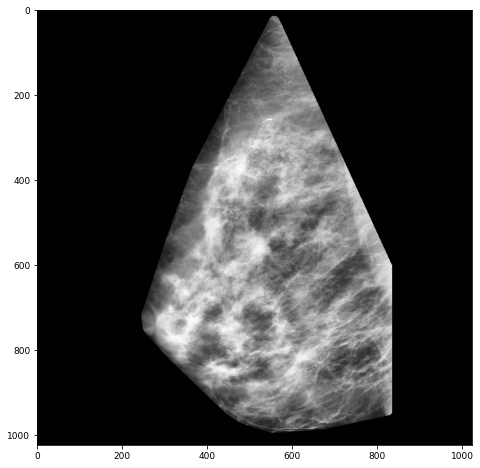

In [ ]:
test_path = dataPath+'/01_allmias_mat_proc_eq/'
#test_image = cv2.imread(abnormal_train_path+'mdb219_output.png', 0)
test_image = cv2.imread(test_path+'mdb219_output.png', 0) #213
#test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(test_image, cmap='gray')
plt.show()

In [ ]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

y_pred_proba:  [[0.54180459 0.45819541]]
y_pred_proba:  [[0.55761604 0.44238396]]
y_pred_proba:  [[0.56792741 0.43207259]]
y_pred_proba:  [[0.50797222 0.49202778]]
y_pred_proba:  [[0.52809981 0.47190019]]
y_pred_proba:  [[0.54359735 0.45640265]]
y_pred_proba:  [[0.53266251 0.46733749]]
y_pred_proba:  [[0.57724826 0.42275174]]
y_pred_proba:  [[0.50599961 0.49400039]]
y_pred_proba:  [[0.52131205 0.47868795]]
y_pred_proba:  [[0.54066965 0.45933035]]
y_pred_proba:  [[0.53827293 0.46172707]]
y_pred_proba:  [[0.54227918 0.45772082]]
y_pred_proba:  [[0.51452236 0.48547764]]
y_pred_proba:  [[0.6412628 0.3587372]]
y_pred_proba:  [[0.56030559 0.43969441]]
y_pred_proba:  [[0.63634658 0.36365342]]
y_pred_proba:  [[0.55869818 0.44130182]]
y_pred_proba:  [[0.52195662 0.47804338]]
y_pred_proba:  [[0.52218362 0.47781638]]
y_pred_proba:  [[0.50784774 0.49215226]]
y_pred_proba:  [[0.51848586 0.48151414]]
y_pred_proba:  [[0.53929732 0.46070268]]
y_pred_proba:  [[0.56719635 0.43280365]]
y_pred_proba:  [[0

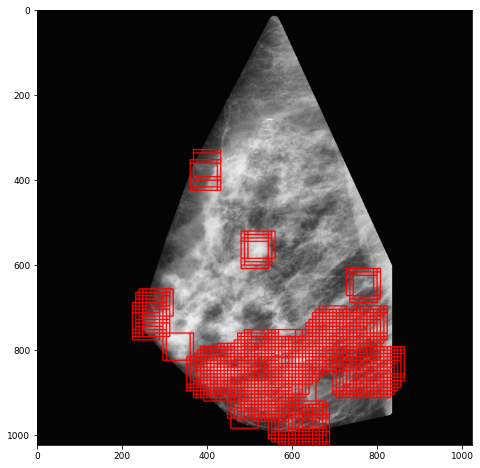

In [ ]:
stepSize = 8
winH = 64
winW = 64
windowSize = (winH, winW)
clone = test_image.copy()
clone2 = cv2.cvtColor(clone, cv2.COLOR_GRAY2RGB)
for (x, y, window) in sliding_window(test_image, stepSize, windowSize):
    # if the current window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
      continue

    # PROCESS WINDOW, EXTRACT FEATURES
    window = test_image[y:y + windowSize[1], x:x + windowSize[0]]
    feats_window = extract_features_one_image(window)
    feats_window_df = pd.DataFrame(feats_window).T
    #y_pred = svclassifier.predict(feats_window_df)
    y_pred_proba = svclassifier.predict_proba(feats_window_df)
    if y_pred_proba.argmax(axis=1) == 0 and y_pred_proba.max(axis=1) >= 0.3: #Umbral de rechazo
      print('y_pred_proba: ', y_pred_proba)
      cv2.rectangle(clone2, (x, y), (x + winW, y + winH), (255,0,0), 2)
    #clone = test_image.copy()
    #cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255), 2)
    #cv2.imshow("Window", clone)
#clone = cv2.cvtColor(clone, cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(clone2)#, cmap='gray')
plt.show()

#Ojo: Coger los patches, el de menor tamaño volverlo el tamaño de patch estándar
#y a los paches que ya están que sean de mayor dimensión, sacarle patches del tamaño del más pequeño